In [13]:
import numpy as np
import pandas as pd
import os
import cv2
import numpy as np
from tqdm import tqdm
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.metrics import Precision, Recall


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [14]:
import os
import cv2
import numpy as np
from tqdm import tqdm  # For progress visualization

# Define class labels
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Initialize training and testing datasets
X_train, y_train = [], []
X_test, y_test = [], []

image_size = 150  # Standardize image size

# Function to load and preprocess images from a given folder
def load_images_from_folder(folder_path, label_index):
    data = []
    labels = []
    for filename in tqdm(os.listdir(folder_path), desc=f"Loading images from {folder_path}"):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (image_size, image_size))  # Resize images
            data.append(img)
            labels.append(label_index)  # Assign numerical label
        else:
            print(f"Failed to load image: {img_path}")
    return data, labels

# Load training data
for label in labels:
    folder_path = os.path.join('/kaggle/input/brain-tumor-classification-mri', 'Training', label)
    data, label_data = load_images_from_folder(folder_path, labels.index(label))
    X_train.extend(data)
    y_train.extend(label_data)

# Load testing data
for label in labels:
    folder_path = os.path.join('/kaggle/input/brain-tumor-classification-mri', 'Testing', label)
    data, label_data = load_images_from_folder(folder_path, labels.index(label))
    X_test.extend(data)
    y_test.extend(label_data)



Loading images from /kaggle/input/brain-tumor-classification-mri/Training/glioma_tumor: 100%|██████████| 826/826 [00:02<00:00, 405.72it/s]
Loading images from /kaggle/input/brain-tumor-classification-mri/Training/meningioma_tumor: 100%|██████████| 822/822 [00:01<00:00, 449.61it/s]
Loading images from /kaggle/input/brain-tumor-classification-mri/Training/no_tumor: 100%|██████████| 395/395 [00:00<00:00, 448.45it/s]
Loading images from /kaggle/input/brain-tumor-classification-mri/Training/pituitary_tumor: 100%|██████████| 827/827 [00:02<00:00, 406.35it/s]
Loading images from /kaggle/input/brain-tumor-classification-mri/Testing/glioma_tumor: 100%|██████████| 100/100 [00:00<00:00, 384.27it/s]
Loading images from /kaggle/input/brain-tumor-classification-mri/Testing/meningioma_tumor: 100%|██████████| 115/115 [00:00<00:00, 468.59it/s]
Loading images from /kaggle/input/brain-tumor-classification-mri/Testing/no_tumor: 100%|██████████| 105/105 [00:00<00:00, 662.40it/s]
Loading images from /kaggle

In [15]:
# Convert lists to NumPy arrays and normalize pixel values to [0,1]
X_train = np.array(X_train) / 255.0
X_test = np.array(X_test) / 255.0
y_train = np.array(y_train)
y_test = np.array(y_test)

# Print dataset shapes
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

# Display class distribution in training data
unique, counts = np.unique(y_train, return_counts=True)
print(f"Class distribution in training data: {dict(zip(unique, counts))}")

Training data shape: (2870, 150, 150, 3)
Testing data shape: (394, 150, 150, 3)
Training labels shape: (2870,)
Testing labels shape: (394,)
Class distribution in training data: {0: 826, 1: 822, 2: 395, 3: 827}


In [16]:
y_train = to_categorical(y_train, num_classes=len(labels))
y_test = to_categorical(y_test, num_classes=len(labels))

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (2296, 150, 150, 3)
Validation data shape: (574, 150, 150, 3)
Test data shape: (394, 150, 150, 3)


In [19]:
# Define the CNN model
model = Sequential([
    
    # First Convolutional Layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)),  # 32 filters of 3x3 kernel
    MaxPooling2D((2, 2)),  # Reduces spatial dimensions by 2x2
    
    # Second Convolutional Layer
    Conv2D(64, (5, 5), activation='relu'),  # 64 filters
    MaxPooling2D((2, 2)),  # Downsampling to reduce computation
    
    # Third Convolutional Layer
    Conv2D(96, (3, 3), activation='relu'),  # 128 filters

    Conv2D(130, (3, 3), activation='relu'),  # 128 filters
    MaxPooling2D((2, 2)),
    
    # Flatten the feature maps into a 1D vector
    Flatten(),

    # Fully Connected Layer
    Dense(128, activation='relu'),  # 128 neurons, ReLU activation
    Dropout(0.5),  # Dropout to prevent overfitting
    
    # Output Layer (Softmax for multi-class classification)
    Dense(len(labels), activation='softmax')  # Number of output neurons = number of classes
])

# Print model architecture
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 70, 70, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 35, 35, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 33, 33, 96)          │          55,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 31, 31, 130)         │         112,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 15, 15, 130)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 29250)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,744,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,964,646 (15.12 MB)

 Trainable params: 3,964,646 (15.12 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [21]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,  
    batch_size=32,
    verbose=1
)

Epoch 1/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 306ms/step - accuracy: 0.4332 - loss: 1.2614 - val_accuracy: 0.5923 - val_loss: 0.8905
Epoch 2/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6380 - loss: 0.8438 - val_accuracy: 0.7352 - val_loss: 0.6359
Epoch 3/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7358 - loss: 0.6407 - val_accuracy: 0.8310 - val_loss: 0.4801
Epoch 4/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8119 - loss: 0.4671 - val_accuracy: 0.8432 - val_loss: 0.3694
Epoch 5/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8543 - loss: 0.3515 - val_accuracy: 0.8780 - val_loss: 0.3102
Epoch 6/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8956 - loss: 0.2881 - val_accuracy: 0.8780 - val_loss: 0.3009
Epoch 7/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9151 - loss: 0.2408 - val_accuracy: 0.8659 - val_loss: 0.3177
Epoch 8/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9223 - loss: 0.1951 - val_accuracy: 0.8606 -

In [22]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.5052 - loss: 12.2135
Test Accuracy: 0.70


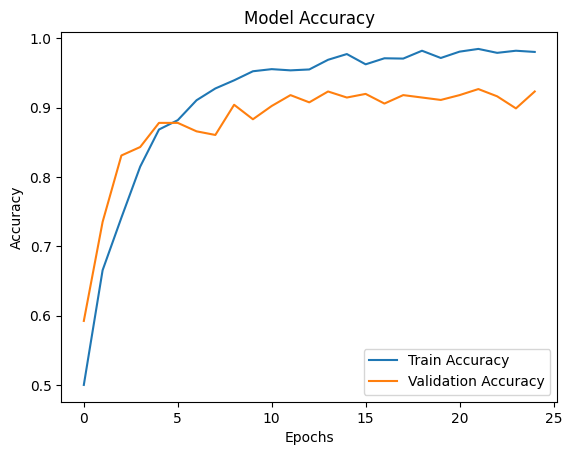

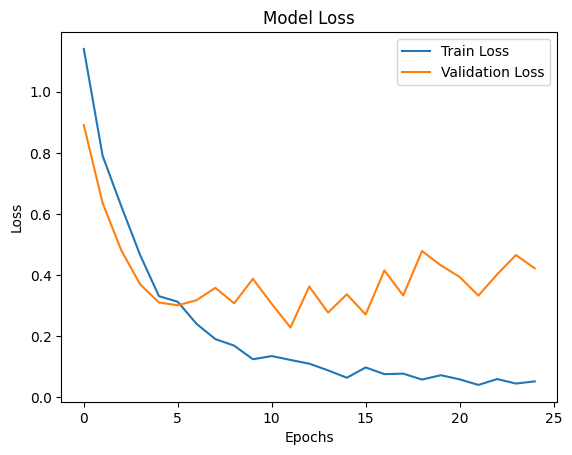

In [23]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5052 - loss: 12.2135
Test Accuracy: 0.70
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       0.89      0.17      0.29       100
        no_tumor       0.74      0.85      0.79       115
meningioma_tumor       0.57      0.99      0.73       105
 pituitary_tumor       0.92      0.76      0.83        74

        accuracy                           0.70       394
       macro avg       0.78      0.69      0.66       394
    weighted avg       0.77      0.70      0.65       394



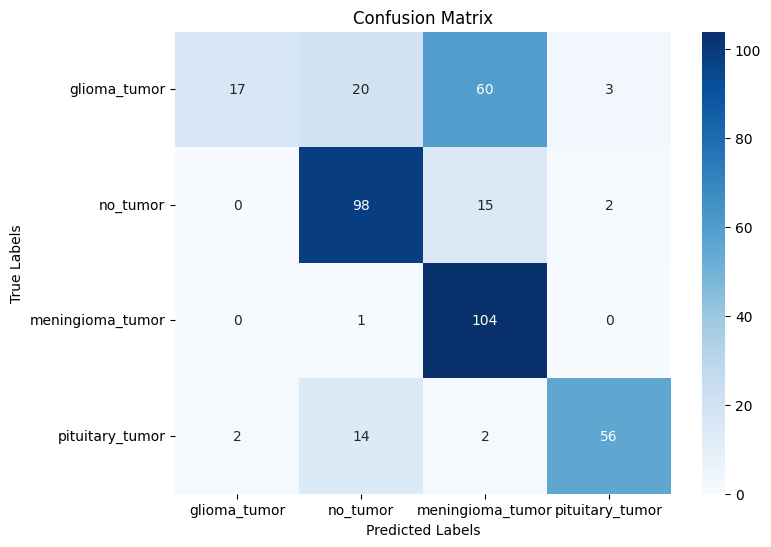

In [24]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Get model predictions
y_pred_probs = model.predict(X_test)  # Get predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print classification report (includes precision, recall, F1-score per class)
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
model.save('/kaggle/working/cnn_model.h5')